# Libraries

##  Remove warnings

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Import libraries

In [2]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
#
import time
import pandas    as pd
import numpy     as np
from   tqdm      import tqdm


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization library
#
import matplotlib.pyplot   as plt 


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Sklearn library
#
from sklearn.preprocessing import StandardScaler


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# PyTorch library
#
import torch
import torch.nn                     as nn
import torch.nn.functional          as F
from   torch.utils.data             import TensorDataset
from   torch.utils.data             import DataLoader
from   torch.autograd               import Variable

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#
# User libraries
#
from utils.EarlyStopping import *
from utils.LRScheduler   import *
from utils.LossFunctions import *
from utils.PerformanceMetrics import RegressionEvaluation

# Parameters

## Setup CUDA

In [3]:
try:
    torch.cuda.init()

    if (torch.cuda.is_available() == True):
        print('[INFO] CUDA is available')

        device = torch.device( 'cuda:0' )
        print('[INFO] Device name: %s' % torch.cuda.get_device_name(0))

    else:
        print('[INFO] CUDA is not available')
        device = torch.device( 'cpu' )
except:
    print('[INFO] CUDA is not available')
    device = torch.device( 'cpu' )

[INFO] CUDA is not available


## Data handling parameters

In [4]:
# Parameters
#
filename   = 'Data/Austin_Weather.csv'

Transformation  = True
Scaling         = 'Standard'

## Neural networks parameters

In [5]:
Lag        = 24
Horizon    =  3
#
epochs     = 200
batch_size =  16

# Data handling

## Import data


In [6]:
# Start timer
#
start = time.time()

# Load data
#
df = pd.read_csv( filename )

print('[INFO] Data imported')
print('[INFO] Time: %.2f seconds' % (time.time() - start))

[INFO] Data imported
[INFO] Time: 0.01 seconds


## Preprocess data

### Set index

In [7]:
# Convert Date to 'datetime64'
#
df['Date'] = df['Date'].astype('datetime64')

# Set index
#
df.set_index('Date', inplace=True)

df.head(3)

,Temperature [Fahrenheit],DewPoint [Fahrenheit],Humidity [%],SeaLevelPressure [inches],Wind [mph],DayOfWeek,Month
Date,,,,,,,
2013-12-21,60,49.0,75.0,29.68,4.0,5,12
2013-12-22,48,36.0,68.0,30.13,6.0,6,12
2013-12-23,45,27.0,52.0,30.49,3.0,0,12


## Set 'target' features

In [8]:
# Get features
#
targetSeries = 'Temperature [Fahrenheit]'

### Create new features based on Date

In [9]:
df['DayOfWeek'] = df.index.dayofweek
df['Month']     = df.index.month

### Split Training/Testing

In [10]:
idx = int( df.shape[0] * 0.9 )

df_train = df[ :idx ]
df_test  = df[ idx: ]

### Visualization

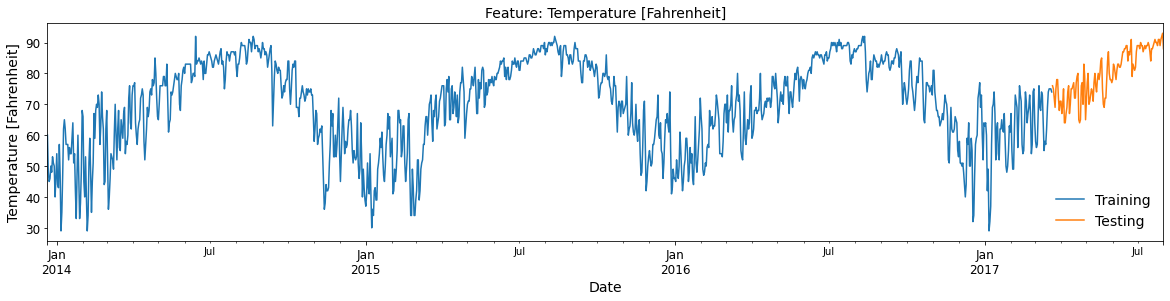

In [11]:
plt.figure( figsize=(20, 4) )

df_train[ targetSeries ].plot( color='tab:blue' )
df_test[ targetSeries ].plot( color='tab:orange')

plt.legend(['Training', 'Testing'], frameon = False, fontsize = 14)
plt.ylabel(targetSeries, size = 14)
plt.xlabel('Date', size = 14)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.title('Feature: {}'.format(targetSeries), size = 14);

### Fixing Lag

In [12]:
df_test = pd.concat([df_train.iloc[-Lag:], df_test])

## Data Transformation

In [13]:
if (Transformation == True):
    
    print('[INFO] Data transformation applied')
    
    Value = df.min().min() + 1
    
    df_train = np.log( df_train + Value)
    df_test  = np.log( df_test  + Value)   
    
else:
    print('[INFO] No data transformation applied.')    

[INFO] Data transformation applied


## Create Training/Testing data

In [14]:
def create_dataset(df = None, Lag = 1, Horizon = 12, targetSeries = None):
    
    if (targetSeries is None):
        targetSeries = df.columns[-1]
    
    dataX, dataY = [], []
    for i in tqdm( range(df.shape[0] + 1  - Lag - Horizon) ):
        
        dataX.append( df.to_numpy()[i:(i+Lag)] )        
        dataY.append( df[ targetSeries ].to_numpy()[i + Lag : i + Lag + Horizon] )
        
        
    return ( np.array(dataX), np.array(dataY) )

In [15]:
trainX, trainY = create_dataset(df = df_train, 
                                Lag = Lag, 
                                Horizon = Horizon, 
                                targetSeries = targetSeries)

testX,  testY  = create_dataset(df = df_test, 
                                Lag = Lag, 
                                Horizon = Horizon, 
                                targetSeries = targetSeries)

print('Training instances:   %6i' % trainX.shape[0])
print('Testing instances:    %6i' % testX.shape[0])

100%|█████████████████████████████████████████████████████████████████████████████| 130/130 [00:00<00:00, 29252.12it/s]

Training instances:     1161
Testing instances:       130


## Scaling

In [16]:
# Transform features by scaling each feature to a given range.
#
if (Scaling == 'MinMax'):
    print('[INFO] Scaling: MinMax')
    
    # Set scaler
    #
    scalerX = MinMaxScaler()

    trainX = scalerX.fit_transform(trainX.reshape(-1, trainX.shape[-1])).reshape(trainX.shape)
    testX  = scalerX.transform(testX.reshape(-1, testX.shape[-1])).reshape(testX.shape)
    
elif (Scaling == 'Robust'):
    print('[INFO] Scaling: Robust')
    
    # Set scaler
    #
    scalerX = RobustScaler()
     
    trainX = scalerX.fit_transform(trainX.reshape(-1, trainX.shape[-1])).reshape(trainX.shape)
    testX  = scalerX.transform(testX.reshape(-1, testX.shape[-1])).reshape(testX.shape)
    
elif (Scaling == 'Standard'):
    print('[INFO] Scaling: Standard')
    
    # Set scaler
    #
    scalerX = StandardScaler()

    trainX = scalerX.fit_transform(trainX.reshape(-1, trainX.shape[-1])).reshape(trainX.shape)
    testX  = scalerX.transform(testX.reshape(-1, testX.shape[-1])).reshape(testX.shape)
    
elif (Scaling == 'None'):
    print('[WARNING] No data scaling applied.')    
else:
    print('[WARNING] Unknown data scaling. No data scaling applied.')

[INFO] Scaling: Standard


## Reshape (needed for PyTorch)

In [28]:
trainX = np.swapaxes(trainX, 1, 2)
testX  = np.swapaxes(testX,  1, 2)

# Forecasting model: Transformer

## Setup dataloaders

In [29]:
sequenceLength = trainX.shape[1]
nFeatures      = trainX.shape[2]

print('[INFO] Sequence length:    ', sequenceLength)
print('[INFO] Number of features: ', nFeatures)

[INFO] Sequence length:     7
[INFO] Number of features:  24


In [30]:
# Create training and test dataloaders
#
num_workers = 0

# how many samples per batch to load
#
batch_size  = 32


# Prepare Data-Loaders
#
trainData = TensorDataset( torch.Tensor(trainX), torch.Tensor(trainY) )
testData  = TensorDataset( torch.Tensor(testX),  torch.Tensor(testY)  )
#
#
train_loader = torch.utils.data.DataLoader(trainData, batch_size=batch_size, num_workers=num_workers)
test_loader  = torch.utils.data.DataLoader(testData,  batch_size=batch_size, num_workers=num_workers)

## Setup model

In [31]:
class ConvModel(nn.Module):
    # d_model : number of features
    def __init__(self, nFeatures = 8):
        super(ConvModel, self).__init__()
            
    
        self.Conv = nn.Sequential(
            # nn.Conv1d(Input channel, Output channel, kernel size)                        
            nn.Conv1d( nFeatures, 128, kernel_size = 4, stride=1, padding=0),   
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(128, 64, kernel_size = 4, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            )
        
        self.fc = nn.Sequential(
            nn.Linear(64*5, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            #
            nn.Linear(128, 3)
        )
        


    def forward(self, x):
        
        # Conv-based
        x = self.Conv( x )
        
        # Reshape (Flatten)
        x = x.view(x.size(0), -1)

        # Dense
        output = self.fc( x )
        
        return output

## Training parameters

In [47]:
# Setup Loss-function
#
criterion = nn.MSELoss()

# Specify loss function
#
optimizer = torch.optim.Adam(params = model.parameters(), 
                             lr     = 1.e-4)


# Define verbose
#
verbose = True


# Early stopping
#
early_stopping = EarlyStopping(patience  = 50,
                               min_delta = 0)


# LR scheduler
#
scheduler = LRScheduler(optimizer = optimizer, 
                        patience  = 10, 
                        min_lr    = 1e-7, 
                        factor    = 0.5, 
                        verbose   = True)

## Training process

In [48]:
# Store training and validation loss
#
Loss = {
         'Train': [], 
         'Valid': []
       }

# Set number at how many iteration the training process (results) will be provided
#
batch_show = (train_loader.dataset.tensors[0].shape[0] // batch_size // 4)



# Main loop - Training process
#
for epoch in range(1, epochs+1):

    # Start timer
    start = time.time()
    
    # Monitor Training/Testing Loss
    train_loss = 0.0
    valid_loss = 0.0
    
    
    
    
    
    ###################
    # Train the model #
    ###################
    batch_idx = 0
    for (x, y) in train_loader:

        # Clear the gradients of all optimized variables
        #
        optimizer.zero_grad()
        
        # Forward pass: compute predicted outputs by passing inputs to the model
        #
        if (torch.cuda.is_available() == True):
            x = torch.tensor(x, dtype=torch.float32).cuda()
            y = torch.tensor(y, dtype=torch.float32).cuda()
        else:
            x = torch.tensor(x, dtype=torch.float32)
            y = torch.tensor(y, dtype=torch.float32)
            
        
        # Forward pass
        #
        outputs = model( x ) 
        
        
        
        # Calculate the loss
        #
        loss = criterion(outputs, y)
        
        
        # Backward pass: compute gradient of the loss with respect to model parameters
        #
        loss.backward()
        
        
        
        # Perform a single optimization step (parameter update)
        #
        optimizer.step()
        
        
        
        # Update running training loss
        #
        train_loss += loss.item() * x.size(0)

        batch_idx  += 1
        if (verbose == True and batch_idx % batch_show == 0):
            print('> Epoch: {} [{:5.0f}/{} ({:.0f}%)]'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader)))        

           
        
    # Print avg training statistics 
    #
    train_loss = train_loss / len( train_loader )
    
    
    
    
    
    with torch.no_grad():
        for (x, y) in test_loader:


            # Forward pass: compute predicted outputs by passing inputs to the model
            #
            if (torch.cuda.is_available() == True):
                x = torch.tensor(x, dtype=torch.float32).cuda()
                y = torch.tensor(y, dtype=torch.float32).cuda()
            else:
                x = torch.tensor(x, dtype=torch.float32)
                y = torch.tensor(y, dtype=torch.float32)


            # Forward pass
            #
            outputs = model( x ) 


            
            # Calculate the loss
            #
            loss = criterion(outputs, y)


            # update running training loss
            #
            valid_loss += loss.item()*x.size(0)

    
    # Print avg training statistics 
    #
    valid_loss = valid_loss / len( test_loader )
    
    
    # Stop timer
    #
    stop  = time.time()
    
    
    # Show training results
    #
    print('\n[INFO] Train Loss: {:.6f} \tValid Loss: {:.6f} \tTime: {:.2f}secs'.format(train_loss, valid_loss, stop-start))
           
    
    # Update best model
    #
    if (epoch == 1):
        Best_validation_score = valid_loss
        
        torch.save(model.state_dict(), 'models/Convolutional.pth')
        print('(Model saved)\n')
    else:
        if (Best_validation_score > valid_loss):
            Best_validation_score = valid_loss
            
            torch.save(model.state_dict(), 'models/Convolutional.pth')
            print('(Model saved)\n')
        else:
            print('\n')
            
     
    
    # Store train/val loss
    #
    Loss['Train'] += [train_loss]
    Loss['Valid'] += [valid_loss]

    

   
    
    # =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
    # Learning rate scheduler
    #
    scheduler(valid_loss)
    
    
    # =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
    # Early Stopping
    #
    if ( early_stopping(valid_loss) ): break    

> Epoch: 1 [  288/1161 (24%)]
> Epoch: 1 [  576/1161 (49%)]
> Epoch: 1 [  864/1161 (73%)]
> Epoch: 1 [ 1152/1161 (97%)]

[INFO] Train Loss: 1036.017356 	Valid Loss: 650.038995 	Time: 0.60secs
(Model saved)

> Epoch: 2 [  288/1161 (24%)]
> Epoch: 2 [  576/1161 (49%)]
> Epoch: 2 [  864/1161 (73%)]
> Epoch: 2 [ 1152/1161 (97%)]

[INFO] Train Loss: 621.655708 	Valid Loss: 462.717456 	Time: 0.65secs
(Model saved)

> Epoch: 3 [  288/1161 (24%)]
> Epoch: 3 [  576/1161 (49%)]
> Epoch: 3 [  864/1161 (73%)]
> Epoch: 3 [ 1152/1161 (97%)]

[INFO] Train Loss: 490.186148 	Valid Loss: 421.764280 	Time: 0.63secs
(Model saved)

> Epoch: 4 [  288/1161 (24%)]
> Epoch: 4 [  576/1161 (49%)]
> Epoch: 4 [  864/1161 (73%)]
> Epoch: 4 [ 1152/1161 (97%)]

[INFO] Train Loss: 441.564570 	Valid Loss: 379.130547 	Time: 0.58secs
(Model saved)

> Epoch: 5 [  288/1161 (24%)]
> Epoch: 5 [  576/1161 (49%)]
> Epoch: 5 [  864/1161 (73%)]
> Epoch: 5 [ 1152/1161 (97%)]

[INFO] Train Loss: 412.850388 	Valid Loss: 350.263765 

[INFO] Train Loss: 47.253631 	Valid Loss: 39.860985 	Time: 0.64secs
(Model saved)

> Epoch: 41 [  288/1161 (24%)]
> Epoch: 41 [  576/1161 (49%)]
> Epoch: 41 [  864/1161 (73%)]
> Epoch: 41 [ 1152/1161 (97%)]

[INFO] Train Loss: 43.208063 	Valid Loss: 41.290958 	Time: 0.65secs


> Epoch: 42 [  288/1161 (24%)]
> Epoch: 42 [  576/1161 (49%)]
> Epoch: 42 [  864/1161 (73%)]
> Epoch: 42 [ 1152/1161 (97%)]

[INFO] Train Loss: 39.370926 	Valid Loss: 35.134443 	Time: 0.64secs
(Model saved)

> Epoch: 43 [  288/1161 (24%)]
> Epoch: 43 [  576/1161 (49%)]
> Epoch: 43 [  864/1161 (73%)]
> Epoch: 43 [ 1152/1161 (97%)]

[INFO] Train Loss: 38.274629 	Valid Loss: 41.169982 	Time: 0.67secs


> Epoch: 44 [  288/1161 (24%)]
> Epoch: 44 [  576/1161 (49%)]
> Epoch: 44 [  864/1161 (73%)]
> Epoch: 44 [ 1152/1161 (97%)]

[INFO] Train Loss: 35.029475 	Valid Loss: 32.650238 	Time: 0.65secs
(Model saved)

> Epoch: 45 [  288/1161 (24%)]
> Epoch: 45 [  576/1161 (49%)]
> Epoch: 45 [  864/1161 (73%)]
> Epoch: 45 [ 1152

> Epoch: 82 [  576/1161 (49%)]
> Epoch: 82 [  864/1161 (73%)]
> Epoch: 82 [ 1152/1161 (97%)]

[INFO] Train Loss: 15.373715 	Valid Loss: 12.408669 	Time: 0.63secs


> Epoch: 83 [  288/1161 (24%)]
> Epoch: 83 [  576/1161 (49%)]
> Epoch: 83 [  864/1161 (73%)]
> Epoch: 83 [ 1152/1161 (97%)]

[INFO] Train Loss: 14.494294 	Valid Loss: 16.194066 	Time: 0.62secs


> Epoch: 84 [  288/1161 (24%)]
> Epoch: 84 [  576/1161 (49%)]
> Epoch: 84 [  864/1161 (73%)]
> Epoch: 84 [ 1152/1161 (97%)]

[INFO] Train Loss: 15.660322 	Valid Loss: 12.039137 	Time: 0.65secs


> Epoch: 85 [  288/1161 (24%)]
> Epoch: 85 [  576/1161 (49%)]
> Epoch: 85 [  864/1161 (73%)]
> Epoch: 85 [ 1152/1161 (97%)]

[INFO] Train Loss: 14.582327 	Valid Loss: 12.589853 	Time: 0.63secs


> Epoch: 86 [  288/1161 (24%)]
> Epoch: 86 [  576/1161 (49%)]
> Epoch: 86 [  864/1161 (73%)]
> Epoch: 86 [ 1152/1161 (97%)]

[INFO] Train Loss: 15.570262 	Valid Loss: 14.593197 	Time: 0.67secs


> Epoch: 87 [  288/1161 (24%)]
> Epoch: 87 [  576/1161 (

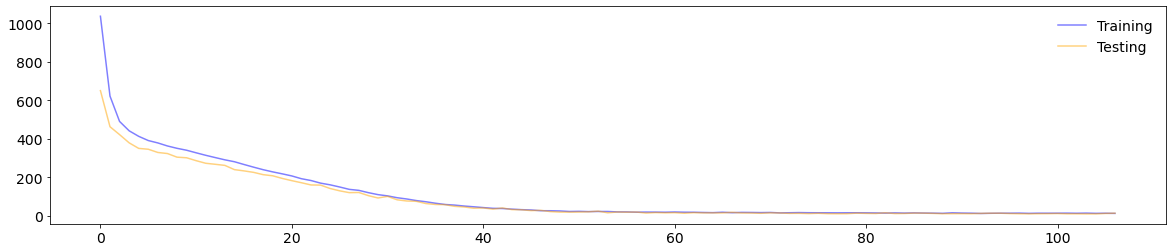

In [49]:
plt.figure( figsize = (20, 4) );

plt.plot( Loss['Train'], color='blue',   alpha= 0.5);
plt.plot( Loss['Valid'], color='orange', alpha= 0.5);

plt.legend(['Training', 'Testing'], frameon = False, fontsize = 14)
plt.xticks(size = 14)
plt.yticks(size = 14);

## Load optimized model

In [50]:
model.load_state_dict(torch.load('models/Convolutional.pth'));
model.eval();

print('[INFO] Model loaded')

[INFO] Model loaded


## Evaluation

### Get predictions

In [51]:
pred = []
with torch.no_grad():
    for (x, y) in test_loader:

        # Forward pass: compute predicted outputs by passing inputs to the model
        #
        if (torch.cuda.is_available() == True):
            x = torch.tensor(x, dtype=torch.float32).cuda()
            y = torch.tensor(y, dtype=torch.float32).cuda()
        else:
            x = torch.tensor(x, dtype=torch.float32)
            y = torch.tensor(y, dtype=torch.float32)

        
        # Forward pass
        #
        outputs = model( x )
        
        # Store predictions
        #
        pred += outputs.detach().tolist()

        
# Convert to Tensor
#
pred = torch.Tensor( pred )

### Calculate Performance on Testing set - Prediction visualization


In [52]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices['Real']       = testY[:,  i]
    Prices['Prediction'] = pred[:, i]

    # Apply inverse transformation   
    #
    if (Transformation == True):
        Prices = np.exp( Prices ) - Value



    # Evaluation
    #
    MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( Prices )

    # Store results
    #
    Performance_Foresting_Model['RMSE']    += [ RMSE    ]
    Performance_Foresting_Model['MAE']     += [ MAE     ]
    Performance_Foresting_Model['SMAPE']   += [ SMAPE   ]
    Performance_Foresting_Model['R2']      += [ R2      ]

    # Present results
    #
    print('Horizon: ', i)
    print('> RMSE:  ', RMSE)
    print('> SMAPE: ', SMAPE)
    print('> R2:    ', R2)
    print()

[INFO] Feature:  Temperature [Fahrenheit]
------------------------------------------------
Horizon:  0
> RMSE:   18.388004355049322
> SMAPE:  23.196001202804034
> R2:     -4.699905038584376

Horizon:  1
> RMSE:   19.662842687302604
> SMAPE:  25.04688431299111
> R2:     -5.38819852195568

Horizon:  2
> RMSE:   19.683710426357962
> SMAPE:  25.275282649807185
> R2:     -5.3705917121556705



## Visualization

[INFO] Feature:  Temperature [Fahrenheit]
------------------------------------------------


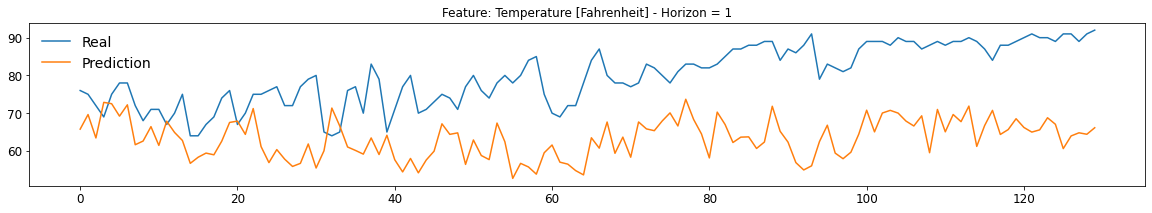

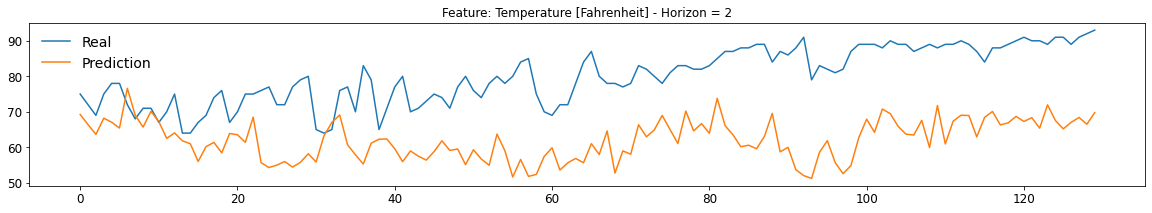

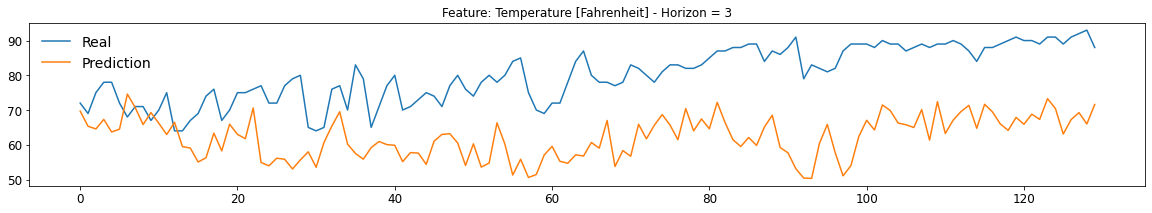

In [53]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices['Real']       = testY[:,  i]
    Prices['Prediction'] = pred[:, i]

    # Apply inverse transformation   
    #
    if (Transformation == True):
        Prices = np.exp( Prices ) - Value
            
            
            
    # Plot Real & Predicted values
    #
    Prices.plot( figsize = (20, 3) )
    #
    plt.title('Feature: {} - Horizon = {}'.format(targetSeries, i+1))
    plt.legend( frameon = False, fontsize = 14)
    plt.xticks(size = 12)
    plt.yticks(size = 12)
    plt.show()        